In [76]:
# Imports
from os import chdir
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import pandas as pd
from IPython.display import clear_output
import seaborn as sns
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from matplotlib.ticker import PercentFormatter

In [2]:
# Move up two directories, to project base directory
chdir("../..")

In [3]:
ddf_reviews = dd.read_parquet("reviews_labeled.parquet")
df_reviews = ddf_reviews.compute()

In [4]:
df_games = pd.read_parquet("data/store_info.parquet")

In [5]:
df_reviews = df_reviews.merge(df_games[['name','price','is_free','recommendations']], left_on='app_name', right_on='name').drop('name', axis=1)

In [6]:
df_reviews["recommendations"] = np.log10(df_reviews["recommendations"].replace(0,10))
df_reviews["price"] = np.log10(df_reviews["price"].replace(0,0.01)*100)
df_reviews.head()

,author_steamid,app_name,is_game_recommended,author_label,app_label,price,is_free,recommendations
0,76561197991126058,ASCENXION,True,0,0,2.999565,False,1.0
1,76561198043369921,ASCENXION,True,0,0,2.999565,False,1.0
2,76561198308633526,ASCENXION,False,1,0,2.999565,False,1.0
3,76561197990036156,ASCENXION,False,1,0,2.999565,False,1.0
4,76561198281676677,ASCENXION,False,0,0,2.999565,False,1.0


In [7]:
df_reviews["labels_tuple"] = [
    *zip(df_reviews["author_label"].values, df_reviews["app_label"].values)
]

X = df_reviews.drop(
    [
        "is_game_recommended",
        "author_steamid",
        "author_steamid",
        "author_label",
        "app_label",
    ],
    axis=1,
)
y = df_reviews["is_game_recommended"]

,app_name,price,is_free,recommendations,labels_tuple,is_game_recommended
2762925,Don't Crash - The Zombie Game,2.298853,False,1.000000,"(21, 16)",True
3557354,Chants of Sennaar,3.300813,False,4.199097,"(0, 0)",True
11802867,The Escapists 2,3.431203,False,4.381855,"(2, 16)",False
3404069,Vampire Survivors,2.698101,False,5.352254,"(2, 11)",True
1443361,Pesterquest,3.078819,False,3.079543,"(42, 18)",True
...,...,...,...,...,...,...
14441669,The Sapling,3.203848,False,3.072250,"(20, 4)",True
7689284,Trine 2: Complete Story,3.300813,False,4.170408,"(1, 1)",True
843474,Bastion,3.175802,False,4.435207,"(1, 1)",True
5482185,Super Amazing Wagon Adventure,2.475671,False,3.212188,"(1, 1)",True


In [ ]:
pipe = Pipeline(
    [
        (
            "transformers",
            ColumnTransformer(
                [
                    ("dropper", "drop", ["labels_tuple", "app_name", "game_positive_reviews", "game_negative_reviews"]),
                    (
                        "scaler",
                        RobustScaler(),
                        [
                            "recommendations",
                            "price",
                            "review_positivity"
                        ],
                    ),
                ],
                remainder="passthrough",
                force_int_remainder_cols=False,
            ),
        ),
        (
            "classifier",
            LogisticRegressionCV(
                n_jobs=-1, solver="newton-cholesky", scoring="neg_log_loss"
            ),
        ),
    ]
)

logreg_labels_only = LogisticRegressionCV(
    n_jobs=-1, solver="newton-cholesky", scoring="neg_log_loss"
)

df_full_model = pd.DataFrame()
df_label_model = pd.DataFrame()
df_majority_model = pd.DataFrame()
for random_state in range(100):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    df_train = X_train.copy()
    df_train["is_game_recommended"] = y

    dict_predictions = (
        df_train.groupby("labels_tuple")["is_game_recommended"].mean().to_dict()
    )
    
    df_train["label_prediction"] = df_train['labels_tuple'].map(dict_predictions)

    X_train["label_prediction"] = (
        X_train["labels_tuple"]
        .map(dict_predictions))
    )
    X_test["label_prediction"] = (
        X_test["labels_tuple"]
        .map(dict_predictions)
        .fillna(df_train.groupby("is_game_recommended")['label_prediction'].mean().mean())
    )

    dict_train_positive_reviews = (
        df_train[df_train["is_game_recommended"] == True]["app_name"]
        .value_counts()
        .to_dict()
    )
    dict_train_negative_reviews = (
        df_train[df_train["is_game_recommended"] == False]["app_name"]
        .value_counts()
        .to_dict()
    )

    X_train["game_positive_reviews"] = X_train["app_name"].map(dict_train_positive_reviews).fillna(0)
    X_test["game_positive_reviews"] = X_test["app_name"].map(dict_train_positive_reviews).fillna(0)

    X_train["game_negative_reviews"] = X_train["app_name"].map(dict_train_negative_reviews).fillna(0)
    X_test["game_negative_reviews"] = X_test["app_name"].map(dict_train_negative_reviews).fillna(0)

    X_train["review_positivity"] = np.log10((X_train["game_positive_reviews"].replace(0,1) / X_train["game_negative_reviews"].replace(0,1)))
    X_test["review_positivity"] = np.log10((X_test["game_positive_reviews"].replace(0,1) / X_test["game_negative_reviews"].replace(0,1)))
    

    pipe.fit(X_train, y_train)
    y_pred_full = pipe.predict(X_test)
    full_model_confusion = confusion_matrix(y_test, y_pred_full)
    df_full_model = pd.concat(
        [df_full_model, pd.DataFrame(full_model_confusion.flatten()).transpose()]
    )

    logreg_labels_only.fit(X_train[["label_prediction"]], y_train)
    y_pred_label = logreg_labels_only.predict(X_test[["label_prediction"]])
    label_model_confusion = confusion_matrix(y_test, y_pred_label)
    
    df_label_model = pd.concat(
        [df_label_model, pd.DataFrame(label_model_confusion.flatten()).transpose()]
    )
    
    majority_model_confusion = confusion_matrix(y_test, np.ones(len(y_test)))
    df_majority_model = pd.concat(
        [df_majority_model, pd.DataFrame(majority_model_confusion.flatten()).transpose()]
    )

In [ ]:
df_full_model['Model'] = 'Full'
df_label_model['Model'] = 'Label'
df_majority_model['Model'] = 'Majority'

df_full_model = df_full_model.rename(columns={0: "TN", 1: "FP", 2: "FN", 3: "TP"}, copy=False)    
df_label_model = df_label_model.rename(columns={0: "TN", 1: "FP", 2: "FN", 3: "TP"}, copy=False)
df_majority_model = df_majority_model.rename(columns={0: "TN", 1: "FP", 2: "FN", 3: "TP"}, copy=False)

for df_results in [df_full_model, df_label_model, df_majority_model]:
    df_results['Accuracy'] = (df_results['TP'] + df_results['TN'])/(df_results['TP'] + df_results['TN'] + df_results['FP'] + df_results['FN'])
    df_results['Recall: Positive'] = (df_results['TP']/(df_results['TP'] + df_results['FN']))
    df_results['Recall: Negative'] = (df_results['TN']/(df_results['TN'] + df_results['FP'])).fillna(0)
    df_results['Precision: Positive'] = (df_results['TP']/(df_results['TP'] + df_results['FP']))
    df_results['Precision: Negative'] = (df_results['TN']/(df_results['TN'] + df_results['FN'])).fillna(0)
    df_results['F1: Positive'] = (2/(df_results['Recall: Positive']**-1 + df_results['Precision: Positive']**-1))
    df_results['F1: Negative'] = (2/(df_results['Recall: Negative']**-1 + df_results['Precision: Negative']**-1)).fillna(0)

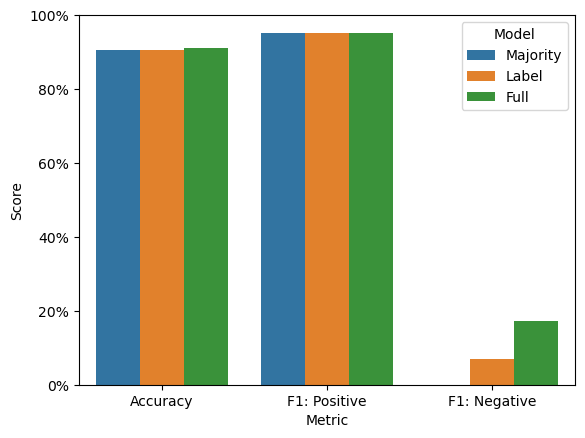

In [79]:
df_model_comparison = pd.melt(
    pd.concat(
        [
            df_majority_model.reset_index(drop=True).reset_index(),
            df_label_model.reset_index(drop=True).reset_index(),
            df_full_model.reset_index(drop=True).reset_index(),
        ]
    ),
    id_vars="Model",
    value_vars=["Accuracy", "F1: Positive", "F1: Negative"],
    var_name="Metric",
    value_name="Score",
)

sns.barplot(df_model_comparison,
            x='Metric',
            y='Score',
            hue='Model')
plt.ylim((0,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()